In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 현재 베스트= 배치 62 /

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import numpy as np

# TensorFlow version 확인
print("TensorFlow version:", tf.__version__)

# 데이터 경로 및 파라미터 설정
batch_size = 62
image_size = (224, 224)
target_size = (224, 224)
classes = ["feather", "normal", "ung"]  #폴더 구성과 동일하게 (위에서 abc면 여기도 abc)


train_dir = "/content/drive/MyDrive/cnn/bee_study/train"
valid_dir = "/content/drive/MyDrive/cnn/bee_study/validation"
test_dir = "/content/drive/MyDrive/cnn/bee_study/test"

# 데이터 증강
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rotation_range=40,        # 회전 각도를 더 크게 설정
    shear_range=0.3,          # 전단 변형을 더 강하게
    zoom_range=0.3,           # 확대/축소 범위를 늘림
    width_shift_range=0.3,    # 가로 이동 범위를 확대
    height_shift_range=0.3,   # 세로 이동 범위를 확대
    brightness_range=(0.8, 1.2),  # 밝기 조정 추가
    fill_mode="nearest",

)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load data
train_data = train_datagen.flow_from_directory(
    train_dir, target_size=target_size, batch_size=batch_size, class_mode="categorical"
)
valid_data = valid_datagen.flow_from_directory(
    valid_dir, target_size=target_size, batch_size=batch_size, class_mode="categorical"
)
test_data = test_datagen.flow_from_directory(
    test_dir, target_size=target_size, batch_size=batch_size, class_mode="categorical", shuffle=False
)

# EfficientNetB0 모델 정의
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Add classification head with L2 regularization
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(
    train_data.num_classes,
    activation="softmax",
    kernel_regularizer=l2(0.01)
)(x)
efficientnet_model = tf.keras.Model(inputs, outputs)

# 포컬 로스 정의 (직렬화 지원)
class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2., alpha=None, **kwargs):
        super(FocalLoss, self).__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weights = tf.pow(1 - y_pred, self.gamma)
        if self.alpha is not None:
            alpha_weight = y_true * self.alpha
            weights *= alpha_weight
        focal_loss = tf.reduce_sum(weights * cross_entropy, axis=-1)
        return focal_loss

    # 직렬화 지원을 위한 메서드 추가
    def get_config(self):
        config = super(FocalLoss, self).get_config()
        config.update({
            "gamma": self.gamma,
            "alpha": self.alpha,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


# 클래스별 가중치 설정
class_weights = np.array([1.0, 1.5, 2.0])
focal_loss = FocalLoss(gamma=2., alpha=class_weights)

# EarlyStopping 콜백 정의
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

# 모델 컴파일
efficientnet_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
    loss=focal_loss,
    metrics=["accuracy"],
)

efficientnet_model.summary()

# Train the model with EarlyStopping
initial_epochs = 20 #이값은 앵간하면 픽스
history = efficientnet_model.fit(
    train_data,
    validation_data=valid_data,
    epochs=initial_epochs,
    callbacks=[early_stopping],
)

# Fine-Tuning
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

efficientnet_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01 / 100),
    loss=focal_loss,
    metrics=["accuracy"],
)

fine_tune_epochs = 100
total_epochs = initial_epochs + fine_tune_epochs

history_fine = efficientnet_model.fit(
    train_data,
    validation_data=valid_data,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=[early_stopping],
)

# 테스트 데이터 평가 및 결과 분석
test_images = np.concatenate([test_data[i][0] for i in range(len(test_data))], axis=0)
test_labels = np.concatenate([test_data[i][1] for i in range(len(test_data))], axis=0)

# 예측 함수 정의
@tf.function
def predict_with_fixed_shape(model, images):
    return model(images)

# 예측 수행
test_predictions = np.argmax(predict_with_fixed_shape(efficientnet_model, test_images), axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Classification report
print("\nClassification Report:\n")
print(classification_report(true_labels, test_predictions, target_names=classes))




TensorFlow version: 2.17.1
Found 576 images belonging to 3 classes.
Found 190 images belonging to 3 classes.
Found 192 images belonging to 3 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           3,843 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 393s 15s/step - accuracy: 0.4541 - loss: 2.5281 - val_accuracy: 0.6000 - val_loss: 1.0749
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 319ms/step - accuracy: 0.6865 - loss: 0.8542 - val_accuracy: 0.6211 - val_loss: 1.1440
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 321ms/step - accuracy: 0.6719 - loss: 0.9556 - val_accuracy: 0.6316 - val_loss: 1.1045
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 319ms/step - accuracy: 0.6860 - loss: 0.8912 - val_accuracy: 0.5895 - val_loss: 2.0067
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 321ms/step - accuracy: 0.7024 - loss: 1.0313 - val_accuracy: 0.7053 - val_loss: 0.9967
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 328ms/step - accuracy: 0.7290 - loss: 0.8085 - val_accuracy: 0.7474 - val_loss: 0.6695
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 318ms/step - accuracy: 0.7299 - loss: 0.9160 - val_accuracy: 0.7316 - val_loss: 0.7585
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 319ms/step - accuracy: 0.7915 - loss: 0.6717 - val_accuracy: 0.6158 - val_

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.17.1


In [ ]:
# Train 데이터 총 개수 확인
print("Total training images:", train_data.n)

# 클래스별 데이터 분포 확인
class_indices = train_data.class_indices
print("Class Indices:", class_indices)

for class_label, class_idx in class_indices.items():
    class_count = sum(train_data.classes == class_idx)
    print(f"Class '{class_label}': {class_count} images")


Total training images: 576
Class Indices: {'feather': 0, 'normal': 1, 'ung': 2}
Class 'feather': 192 images
Class 'normal': 192 images
Class 'ung': 192 images


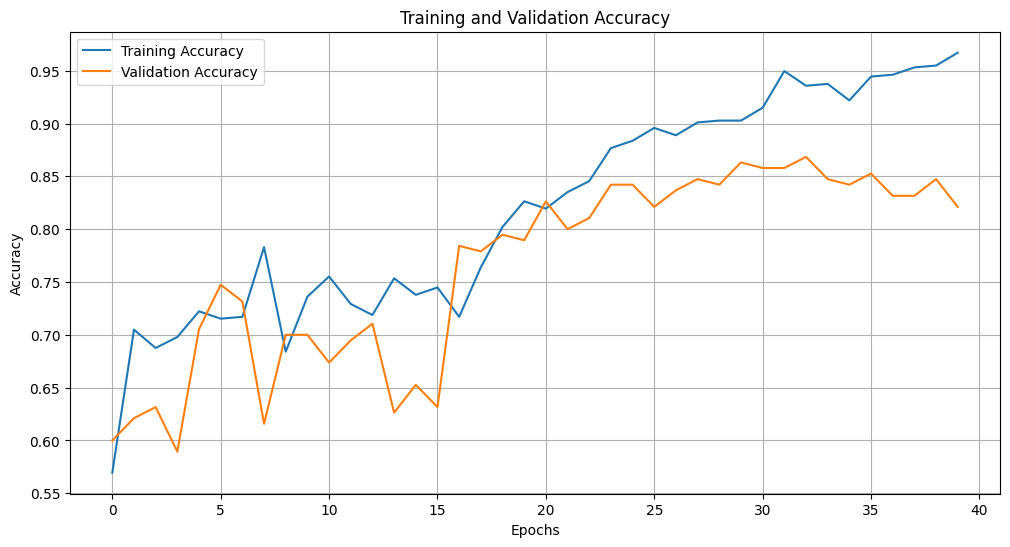

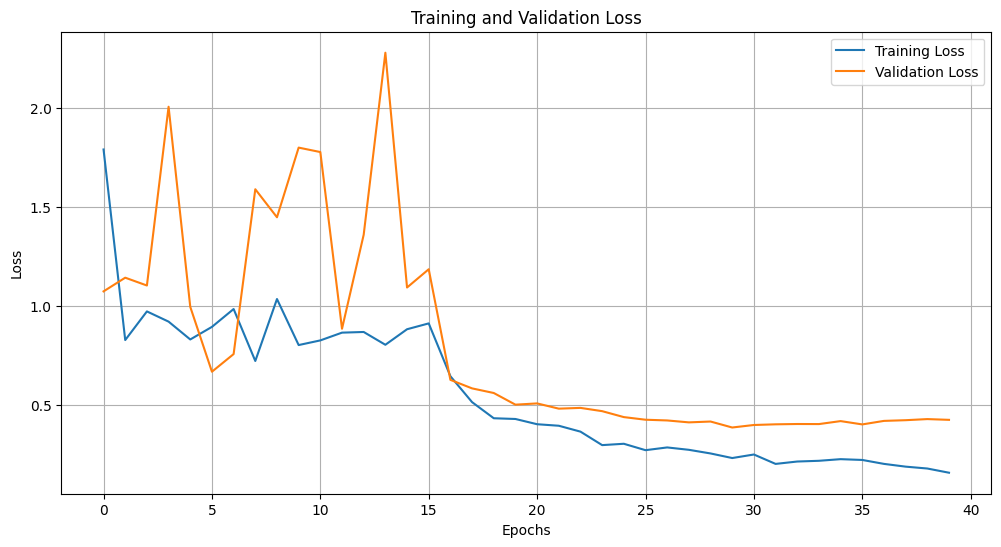

In [ ]:
# Training and validation accuracy
train_acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

# Training and validation loss
train_loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

# Epochs range
total_epochs = range(len(train_acc))

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(total_epochs, train_acc, label='Training Accuracy')
plt.plot(total_epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(total_epochs, train_loss, label='Training Loss')
plt.plot(total_epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score
import numpy as np

# 테스트 데이터 예측
test_predictions = np.argmax(efficientnet_model.predict(test_data), axis=1)
true_labels = test_data.classes
class_labels = list(test_data.class_indices.keys())

# 정확도, 정밀도, 재현율, F1 Score 계산
accuracy = accuracy_score(true_labels, test_predictions)
precision_macro = precision_score(true_labels, test_predictions, average="macro")  # 클래스 간 동일 가중치
precision_weighted = precision_score(true_labels, test_predictions, average="weighted")  # 클래스 비율 가중치
recall = recall_score(true_labels, test_predictions, average="macro")
f1 = f1_score(true_labels, test_predictions, average="macro")

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (Macro Average): {precision_macro:.2f}")
print(f"Precision (Weighted Average): {precision_weighted:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# 상세 분류 보고서 출력
print("\nClassification Report:\n")
print(classification_report(true_labels, test_predictions, target_names=class_labels))


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step
Accuracy: 0.86
Precision (Macro Average): 0.87
Precision (Weighted Average): 0.87
Recall: 0.86
F1 Score: 0.86

Classification Report:

              precision    recall  f1-score   support

     feather       1.00      0.89      0.94        64
      normal       0.79      0.86      0.82        64
         ung       0.82      0.83      0.82        64

    accuracy                           0.86       192
   macro avg       0.87      0.86      0.86       192
weighted avg       0.87      0.86      0.86       192



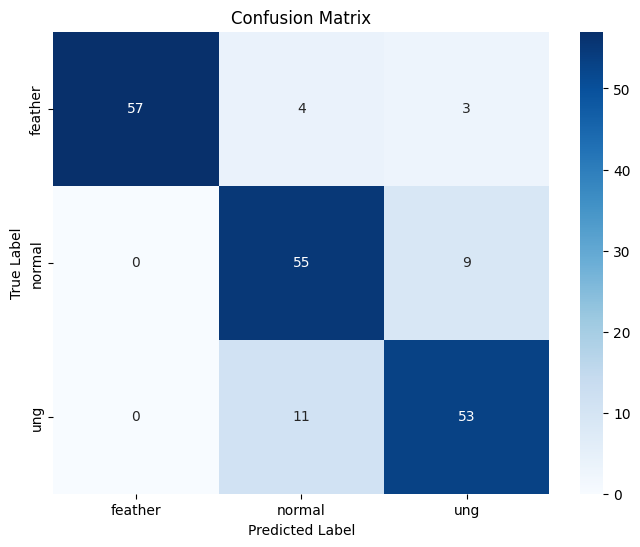

In [ ]:
#혼동 행렬
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# keras 확장자로 저장


efficientnet_model.save('bee_image_model3.keras')


In [ ]:
# 단일 이미지를 numpy 배열로 변환
def load_and_process_image(image_path, target_size=(224, 224)):
    """
    이미지를 불러오고, ImageDataGenerator로 전처리합니다.
    """
    # 올바르게 load_img와 img_to_array 호출
    image_path = '/content/tm2.jpg'
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # 배치 차원 추가
    return single_image_datagen.standardize(img_array)  # ImageDataGenerator로 전처리

# 이미지 불러오기 및 전처리
single_image = load_and_process_image(image_path)

# 모델 예측 수행
predictions = efficientnet_model.predict(single_image)
predicted_class = np.argmax(predictions)

# 결과 출력
print(f"Predicted class: {classes[predicted_class]}")
print(f"Class probabilities: {predictions}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted class: normal
Class probabilities: [[0.2710596  0.6275768  0.10136361]]


In [ ]:
# 모델 저장
efficientnet_model.save('./bee_image_model.keras', save_format='keras')
print("모델 저장 완료!")


모델 저장 완료!
